## Converting points to raster

In [44]:
%pip install rasterio


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Import Libraries and set paths

In [45]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio

from streetscapes import conf
from streetscapes.functions import load_city_subset

In [46]:
data_dir = conf.DATA_DIR / "data"
parquet_dir =  data_dir / "parquet"

### Create Geopandas dataframe

Load streetscapes dataset and select the city you want to analyse. 

In [47]:
all = pd.read_parquet(parquet_dir / f"streetscapes.parquet")
amsterdam = load_city_subset("Amsterdam")

Streetscapes | 2025-02-21@00:34:01 | Loading 'Amsterdam.parquet'...


Create geopandas dataframe and set projection

In [105]:
amsterdam_gdf = gpd.GeoDataFrame(amsterdam, geometry=gpd.points_from_xy(amsterdam.lon, amsterdam.lat), crs="EPSG:4326")
amsterdam_projected = amsterdam_gdf.to_crs(28992)

### Create template raster

To rasterise points, you first need to create a template raster with the same extents and CRS as your input point data. 

In [106]:
bounds = amsterdam_projected.total_bounds
horizontal_resolution = 100
transform = rasterio.transform.from_origin(
    west=bounds[0], 
    north=bounds[3], 
    xsize=horizontal_resolution, 
    ysize=horizontal_resolution
)
transform

Affine(100.0, 0.0, np.float64(120311.91265181282),
       0.0, -100.0, np.float64(487646.1447921692))

Calculate output shape

In [107]:
rows = math.ceil((bounds[3] - bounds[1]) / horizontal_resolution)
cols = math.ceil((bounds[2] - bounds[0]) / horizontal_resolution)
shape = (rows, cols)
shape

(16, 16)

Create pairs of coordinates to value

In [108]:
g = [(g, v) for g, v in amsterdam_projected[['geometry', 'Beautiful']] \
        .dropna(subset='Beautiful')
        .to_numpy() \
        .tolist()]
g[:5]

[(<POINT (121365.398 486834.476)>, 7.68),
 (<POINT (121333.958 486778.2)>, 5.02),
 (<POINT (121210.294 486486.744)>, 8.63),
 (<POINT (121793.059 487024.735)>, 4.47),
 (<POINT (121763.647 486237.69)>, 6.1)]

Rasterise: Map to template raster

In [109]:
raster = rasterio.features.rasterize(
    shapes=g,
    out_shape=shape,
    transform=transform,
)
raster

array([[7.74, 4.63, 7.5 , 8.85, 4.83, 9.32, 5.1 , 9.24, 2.57, 3.86, 7.47,
        7.13, 3.22, 5.61, 6.33, 5.12],
       [3.86, 3.8 , 5.62, 5.56, 4.33, 6.1 , 8.06, 1.12, 2.84, 5.64, 3.84,
        5.96, 5.56, 6.15, 5.71, 6.17],
       [3.45, 6.9 , 8.2 , 6.62, 5.34, 4.64, 8.28, 2.9 , 3.19, 6.8 , 3.83,
        3.38, 0.  , 8.97, 6.99, 0.  ],
       [7.21, 7.12, 5.99, 3.51, 8.24, 6.01, 7.7 , 8.18, 3.46, 7.31, 5.95,
        2.53, 7.37, 8.94, 6.5 , 5.9 ],
       [7.82, 6.9 , 2.7 , 8.59, 7.02, 0.  , 5.19, 3.48, 3.91, 7.28, 9.27,
        5.6 , 8.53, 2.48, 7.15, 7.95],
       [8.39, 8.37, 6.38, 7.35, 7.6 , 8.39, 9.57, 9.02, 6.87, 4.95, 5.87,
        4.33, 5.54, 7.06, 6.46, 5.65],
       [8.35, 6.57, 5.37, 8.26, 8.49, 9.07, 6.9 , 9.05, 8.74, 1.85, 7.37,
        7.09, 8.33, 6.91, 7.33, 0.  ],
       [7.46, 3.23, 1.57, 8.52, 9.62, 6.12, 7.36, 5.59, 3.81, 6.18, 6.34,
        8.05, 5.34, 5.47, 6.64, 0.  ],
       [4.95, 6.74, 4.85, 8.28, 9.24, 7.56, 8.86, 7.83, 7.06, 3.43, 5.18,
        4.31, 5.63, 5.

### Plot the output

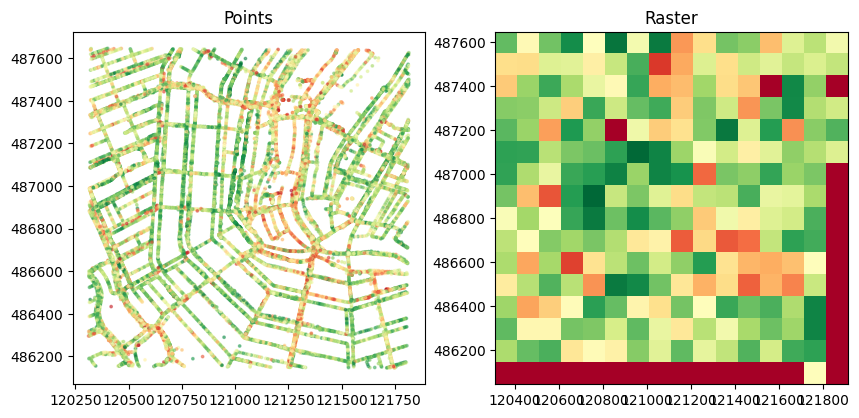

In [127]:

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plot the GeoDataFrame on the first subplot
amsterdam_projected.plot(column='Beautiful', ax=ax1, cmap='RdYlGn', markersize=3, alpha=0.5)
ax1.set_title('Points')

# Plot the raster on the second subplot
rasterio.plot.show(raster, transform=transform, ax=ax2, cmap='RdYlGn')
ax2.set_title('Raster')

# Show the plot
plt.show()

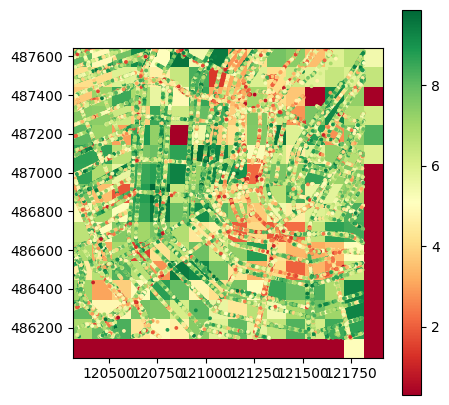

In [129]:
# Combined plot
fig, ax = plt.subplots(figsize=(5, 5))

# Plot points
amsterdam_projected.plot(column='Beautiful', ax=ax, cmap='RdYlGn', legend=True, markersize=3)

# Plot raster
rasterio.plot.show(raster, transform=transform, ax=ax, cmap='RdYlGn')

# Show the plot
plt.show()